In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from utils import summarize_strategies, compute_turnover, drawdown

In [2]:
## User settings
min_leverage = 0
max_leverage = 1000
f = 0.5 # fractional Kelly
half_life = 20
window_size = 2520
max_total_leverage = 5
t_cost = 0.001

In [3]:
# Read and process datasets
dataset = 'data/10_Industry_Portfolios_Daily.csv'
ffdaily = 'data/FFDaily.xlsx'

df_industry = pd.read_csv(dataset)
df_industry = df_industry.rename(columns={
    "Unnamed: 0": "Date"
})
df_industry['Date'] = pd.to_datetime(df_industry['Date'], format='%Y%m%d')
df_industry[df_industry.columns.difference(['Date'])] = df_industry.drop('Date', axis=1) / 100

In [4]:
df_FF = pd.read_excel(ffdaily)
df_FF['Date'] = pd.to_datetime(df_FF['Date'], format='%Y%m%d')
df_FF = df_FF[['Date', 'RF']]
df_FF['RF'] = df_FF['RF'] / 100

In [5]:
# Merge data an set sample period
df = pd.merge(df_industry, df_FF, on='Date', how='inner')
start_date = '1926-07-01'
end_date = '2024-12-31'
df = df[(df['Date'] >= start_date) & (df['Date'] <= end_date)]
df = df.rename(columns={
    "RF": "rf"
})

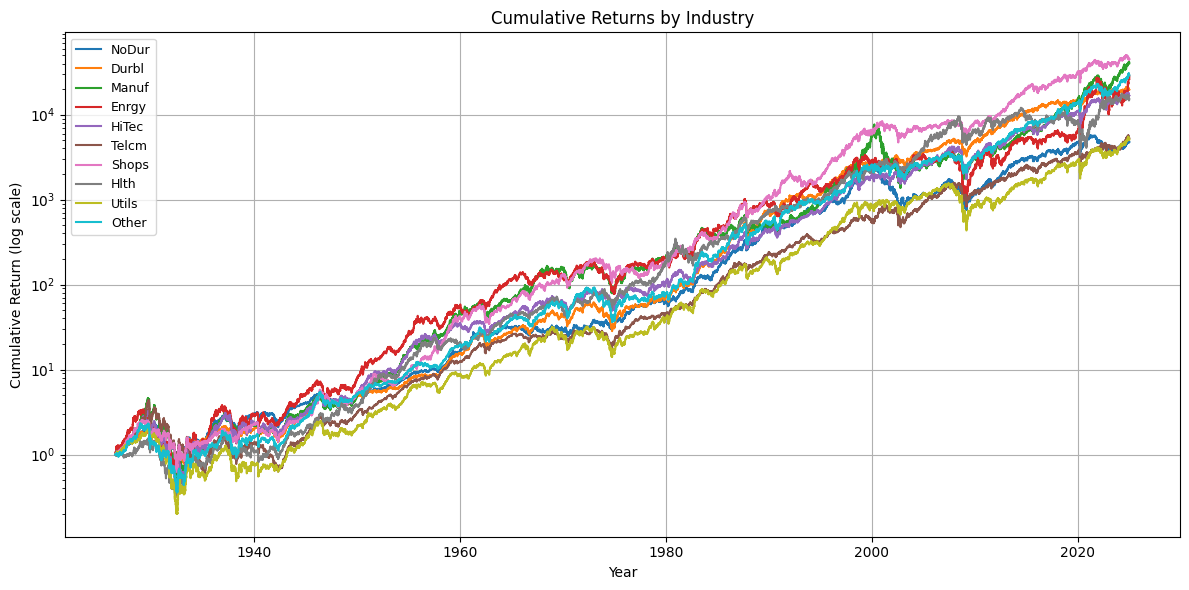

In [6]:
#List all asset columns 
assets = [col for col in df.columns if col not in ['Date', 'rf']]

# Compute cumulative returns for each asset
cum_returns = {}
for col in assets:
    cum_returns[col] = np.cumprod(1 + df[col])

# Plot cumulative returns (Not in paper)
plt.figure(figsize=(12, 6))

for col in assets:
    plt.semilogy(df['Date'], cum_returns[col], label=col)

plt.xlabel('Year')
plt.ylabel('Cumulative Return (log scale)')
plt.title('Cumulative Returns by Industry')
plt.legend(loc='upper left', fontsize=9)
plt.grid(True)
plt.tight_layout()
plt.show()

In [7]:
df = df.copy()

In [8]:
# Total and excess returns
for asset in assets:
    df[f'total_returns_{asset}'] = df[asset]
    df[f'xs_returns_{asset}'] = df[f'total_returns_{asset}'] - df['rf']

# Volatility estimation (EWM of squared excess returns)
for asset in assets:
    df[f'vol_{asset}'] = df[f'xs_returns_{asset}']**2
    df[f'vol_{asset}'] = df[f'vol_{asset}'].ewm(halflife=half_life, adjust=False).mean()
    df[f'vol_{asset}'] = np.sqrt(df[f'vol_{asset}'])

# Lagged volatility (prediction input)
for asset in assets:
    df[f'vol_pred_{asset}'] = df[f'vol_{asset}'].shift(1)

# Rolling expected return estimation
for asset in assets:
    df[f'mu_hat_{asset}'] = df[f'xs_returns_{asset}'].rolling(
        window=window_size, min_periods=window_size).mean().shift(1)

In [9]:
df = df.dropna().reset_index(drop=True)

In [10]:
total_returns_cols = [f'total_returns_{a}' for a in assets]
total_returns_df = df[total_returns_cols].copy()

In [11]:
# Assign constant equal weights (same style as Kelly)
for asset in assets:
    w_col = f'equal_w_{asset}'
    df[w_col] = 1 / len(assets)

# Compute weighted excess return per asset
for asset in assets:
    xs_col = f'xs_returns_{asset}'
    w_col = f'equal_w_{asset}'
    ret_col = f'equal_return_{asset}'
    df[ret_col] = df[xs_col] * df[w_col]

# Sum across assets to get portfolio-level excess return
equal_return_cols = [f'equal_return_{asset}' for asset in assets]
df['equal_xs_returns'] = df[equal_return_cols].sum(axis=1)

In [12]:
equal_weight_cols = [f'equal_w_{a}' for a in assets]
equal_weights_df = df[equal_weight_cols].copy()

In [13]:
# Compute Kelly weights for each asset
for asset in assets:
    mu_col = f'mu_hat_{asset}'
    vol_col = f'vol_pred_{asset}'
    w_col = f'kelly_w_{asset}'

    df[w_col] = np.clip(((df[mu_col] / df[vol_col]**2) * f), min_leverage, max_leverage)

In [14]:
kelly_weight_cols = [f'kelly_w_{a}' for a in assets]
kelly_weights_before_rescale_df = df[kelly_weight_cols].copy()
df['kelly_total_leverage'] = df[kelly_weight_cols].sum(axis=1)

In [15]:
# Rescale weights proportionally if total leverage > max_total_leverage
over_leverage = df['kelly_total_leverage'] > max_total_leverage

for asset in assets:
    w_col = f'kelly_w_{asset}'
    df.loc[over_leverage, w_col] = (
        df.loc[over_leverage, w_col] /
        df.loc[over_leverage, 'kelly_total_leverage']
    ) * max_total_leverage

In [16]:
# Compute weighted return per asset
for asset in assets:
    xs_col = f'xs_returns_{asset}'
    w_col = f'kelly_w_{asset}'
    ret_col = f'kelly_return_{asset}'
    df[ret_col] = df[xs_col] * df[w_col]

# Sum across all assets to get portfolio excess return
kelly_return_cols = [f'kelly_return_{asset}' for asset in assets]
df['kelly_xs_returns'] = df[kelly_return_cols].sum(axis=1)

In [17]:
kelly_weight_cols_after_rescale = [f'kelly_w_{a}' for a in assets]
kelly_weights_df = df[kelly_weight_cols_after_rescale].copy()

In [18]:
# Compute target (mean) volatility per asset
mean_vols = {asset: df[f'vol_{asset}'].mean() for asset in assets}

# Compute vol-target weights and returns per asset (with asset-level scaling)
for asset in assets:
    vol_col = f'vol_pred_{asset}'
    eq_col = f'equal_return_{asset}'
    xs_col = f'xs_returns_{asset}'

    w_col = f'vol_w_{asset}'
    r_col = f'vol_return_{asset}'

    # Initial unscaled weight
    df[w_col] = mean_vols[asset] / df[vol_col]
    df[r_col] = df[xs_col] * df[w_col]

    # Scale per asset to match its own benchmark volatility
    strategy_std = np.std(df[r_col], ddof=1)
    benchmark_std = np.std(df[eq_col], ddof=1)
    scaling = benchmark_std / strategy_std

    df[w_col] *= scaling
    df[w_col] = df[w_col].clip(lower=min_leverage, upper=max_leverage)
    df[r_col] = df[xs_col] * df[w_col]

In [19]:
# Store raw weights and compute total leverage
vol_weight_cols = [f'vol_w_{a}' for a in assets]
vol_weights_before_rescale_df = df[vol_weight_cols].copy()
df['vol_total_leverage'] = df[vol_weight_cols].sum(axis=1)

In [20]:
# Rescale weights proportionally if total leverage > max_total_leverage
over_leverage = df['vol_total_leverage'] > max_total_leverage

for asset in assets:
    w_col = f'vol_w_{asset}'
    df.loc[over_leverage, w_col] = (
        df.loc[over_leverage, w_col] /
        df.loc[over_leverage, 'vol_total_leverage']
    ) * max_total_leverage

    # Recompute return using rescaled weight
    xs_col = f'equal_return_{asset}'
    r_col = f'vol_return_{asset}'
    df.loc[over_leverage, r_col] = df.loc[over_leverage, xs_col] * df.loc[over_leverage, w_col]

# Compute total volatility-targeted excess return
vol_return_cols = [f'vol_return_{a}' for a in assets]
df['vol_xs_returns'] = df[vol_return_cols].sum(axis=1)

In [21]:
vol_weight_cols_after_rescale = [f'vol_w_{a}' for a in assets]
vol_weights_df = df[vol_weight_cols_after_rescale].copy()

In [22]:
# Obtaining total weights
df['kelly_tot_w'] = kelly_weights_df.sum(axis=1)
df['vol_tot_w'] = vol_weights_df.sum(axis=1)
df['equal_tot_w'] = equal_weights_df.sum(axis=1)

In [23]:
# Total returns 
df['kelly_total_returns']     = df['kelly_xs_returns']     + df['rf']
df['vol_total_returns']       = df['vol_xs_returns']       + df['rf']
df['benchmark_total_returns'] = df['equal_xs_returns']     + df['rf']

In [24]:
BenchmarkNAV = np.cumprod(1 + df['benchmark_total_returns'])
VolNAV = np.cumprod(1 + df['vol_total_returns'])
KellyNAV = np.cumprod(1 + df['kelly_total_returns'])

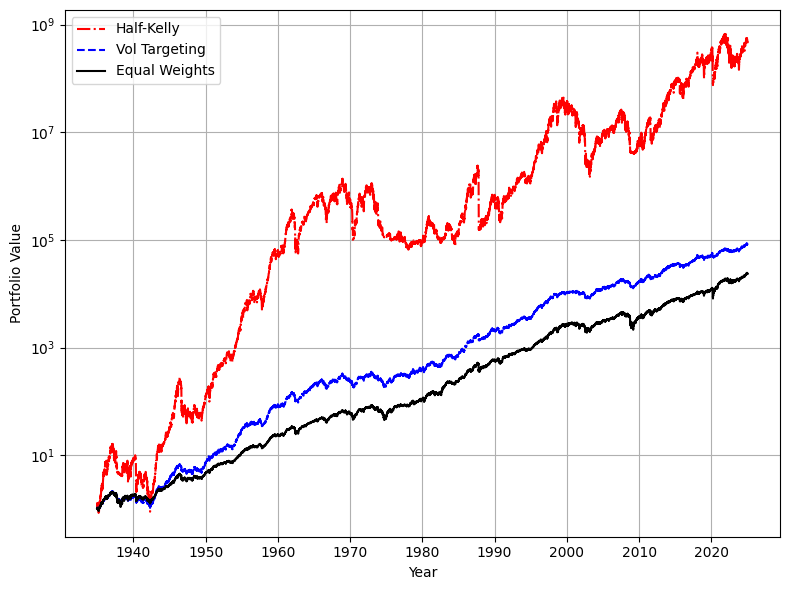

In [25]:
# Wealth paths (Not in paper)
plt.figure(figsize=(8, 6))

plt.semilogy(df['Date'], KellyNAV, 'r-.', label='Half-Kelly')
plt.semilogy(df['Date'], VolNAV, 'b--', label='Vol Targeting')
plt.semilogy(df['Date'], BenchmarkNAV, 'k-', label='Equal Weights')

plt.xlabel('Year')
plt.ylabel('Portfolio Value')
plt.legend(loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

In [26]:
returns_dict = {
    'Equal Weights': df['equal_xs_returns'],
    'Volatility Targeting': df['vol_xs_returns'],
    'Kelly Criterion': df['kelly_xs_returns']
}

rf_dict = {
    'Equal Weights': df['rf'],
    'Volatility Targeting': df['rf'],
    'Kelly Criterion': df['rf']
}

weights_dict = {
    "Equal Weights": df['equal_tot_w'],
    "Volatility Targeting": df['vol_tot_w'],
    "Kelly Criterion": df['kelly_tot_w'],
}

# Table 9
results_df = summarize_strategies(returns_dict, rf_dict, weights_dict, rebalancing_freq=252)
summary_transposed = results_df.set_index('Strategy').T
display(summary_transposed.round(3))

Strategy,Equal Weights,Volatility Targeting,Kelly Criterion
Final Log Wealth,10.063,11.314,1.992900e+01
Average Allocation,1.000,1.341,4.631000e+00
Arithm. Total Return (%),11.915,13.251,3.818500e+01
Arithm. Excess Return (%),8.690,10.027,3.496000e+01
SR,0.596,0.692,6.250000e-01
Geom. Total Return (%),10.848,12.197,2.148800e+01
Geom. Excess Return (%),7.623,8.973,1.826400e+01
Geom. SR,0.523,0.619,3.260000e-01
Max Drawdown,-0.525,-0.513,-9.660000e-01
Terminal Wealth,23450.402,81986.386,4.518045e+08


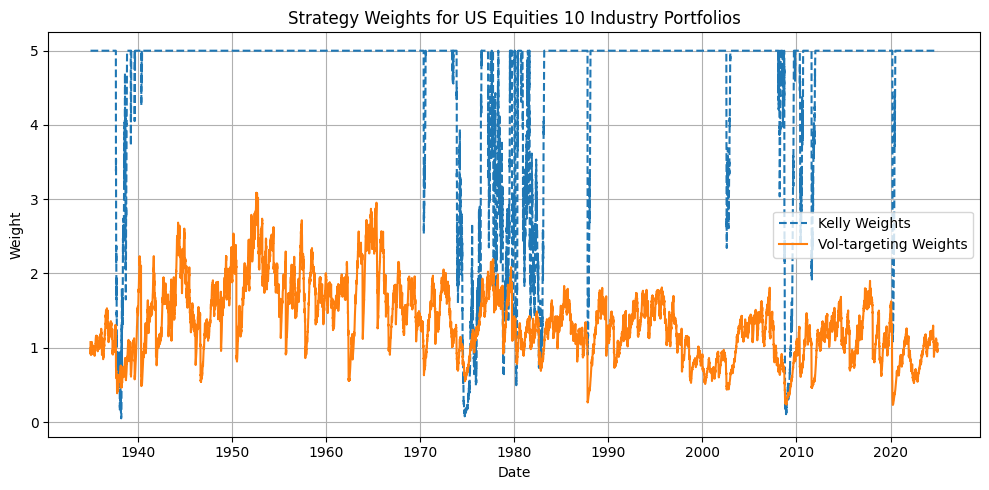

In [27]:
vol_weights_df_total = vol_weights_df.sum(axis=1)
kelly_weights_df_total= kelly_weights_df.sum(axis=1)

# Plot weights over time (Not in paper)
plt.figure(figsize=(10, 5))
plt.plot(df['Date'], kelly_weights_df_total, label='Kelly Weights', linestyle='--')
plt.plot(df['Date'], vol_weights_df_total, label='Vol-targeting Weights', linestyle='-')
plt.xlabel('Date')
plt.ylabel('Weight')
plt.title('Strategy Weights for US Equities 10 Industry Portfolios')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Drawdowns

In [28]:
drawdown_kelly = drawdown(KellyNAV)
drawdown_vol = drawdown(VolNAV)
drawdown_equal = drawdown(BenchmarkNAV)

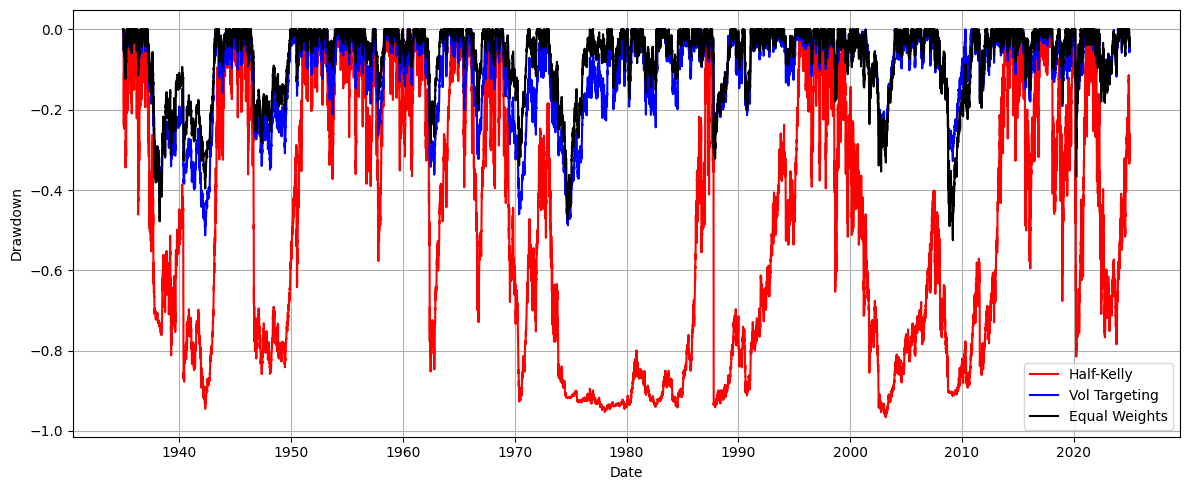

In [29]:
# Plot drawdowns (Figure 8)
plt.figure(figsize=(12, 5))
plt.plot(df['Date'], drawdown_kelly, label='Half-Kelly', color='r')
plt.plot(df['Date'], drawdown_vol, label='Vol Targeting', color='b')
plt.plot(df['Date'], drawdown_equal, label='Equal Weights', color='k')

plt.ylabel('Drawdown')
plt.xlabel('Date')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Transaction Costs

In [30]:
# Computing turnover
turnover_equal_weights = np.zeros(len(df))
turnover_vol = np.zeros(len(df))
turnover_kelly = np.zeros(len(df))

for i in range(len(df) - 1):
    asset_ret = total_returns_df.iloc[i].values     
    rf_ret = df['rf'].iloc[i]                       

    turnover_equal_weights[i + 1], _ = compute_turnover(equal_weights_df.iloc[i].values, equal_weights_df.iloc[i + 1].values, asset_ret, rf_ret)
    turnover_vol[i + 1], _ = compute_turnover(vol_weights_df.iloc[i].values, vol_weights_df.iloc[i + 1].values, asset_ret, rf_ret)
    turnover_kelly[i + 1], _ = compute_turnover(kelly_weights_df.iloc[i].values, kelly_weights_df.iloc[i + 1].values, asset_ret, rf_ret)
    
turnover_equal_weights[0] = 1
turnover_vol[0] = 1
turnover_kelly[0] = 1

In [31]:
xs_returns_equal_tc = df['equal_xs_returns'] - (t_cost * turnover_equal_weights)
xs_returns_vol_tc = df['vol_xs_returns'] - (t_cost * turnover_vol)
xs_returns_kelly_tc = df['kelly_xs_returns'] - (t_cost * turnover_kelly)

In [32]:
BenchmarkNAV_tc = np.cumprod(1 + xs_returns_equal_tc + df['rf'])
VolNAV_tc = np.cumprod(1 + xs_returns_vol_tc + df['rf'])
KellyNAV_tc = np.cumprod(1 + xs_returns_kelly_tc + df['rf'])

In [33]:
# Turnover
print(turnover_equal_weights.mean().round(3))
print(turnover_vol.mean().round(3))
print(turnover_kelly.mean().round(3))

0.004
0.026
0.156


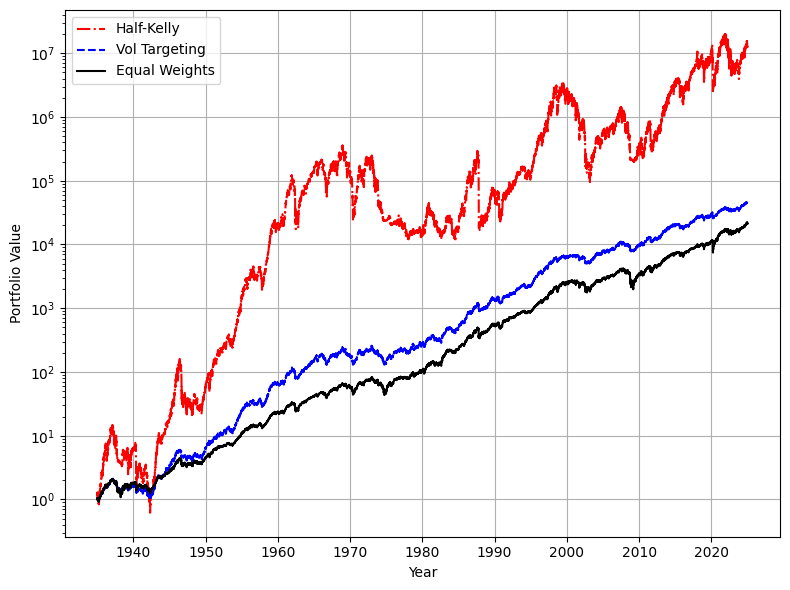

In [34]:
# Wealth paths (not in paper)
plt.figure(figsize=(8, 6))

plt.semilogy(df['Date'], KellyNAV_tc, 'r-.', label='Half-Kelly')
plt.semilogy(df['Date'], VolNAV_tc, 'b--', label='Vol Targeting')
plt.semilogy(df['Date'], BenchmarkNAV_tc, 'k-', label='Equal Weights')

plt.xlabel('Year')
plt.ylabel('Portfolio Value')
plt.legend(loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

In [35]:
returns_dict_TC = {
    'Equal Weights': xs_returns_equal_tc,
    'Volatility Targeting': xs_returns_vol_tc,
    'Kelly Criterion': xs_returns_kelly_tc
}

rf_dict_TC = {
    'Equal Weights': df['rf'],
    'Volatility Targeting': df['rf'],
    'Kelly Criterion': df['rf']
}

# Table 9
results_df_TC = summarize_strategies(returns_dict_TC, rf_dict_TC, weights_dict, rebalancing_freq=252)
summary_transposed_TC = results_df_TC.set_index('Strategy').T
display(summary_transposed_TC.round(3))

Strategy,Equal Weights,Volatility Targeting,Kelly Criterion
Final Log Wealth,9.966,10.708,1.627400e+01
Average Allocation,1.000,1.341,4.631000e+00
Arithm. Total Return (%),11.811,12.598,3.425200e+01
Arithm. Excess Return (%),8.586,9.373,3.102800e+01
SR,0.589,0.647,5.540000e-01
Geom. Total Return (%),10.744,11.544,1.754600e+01
Geom. Excess Return (%),7.519,8.320,1.432100e+01
Geom. SR,0.516,0.574,2.560000e-01
Max Drawdown,-0.526,-0.530,-9.720000e-01
Terminal Wealth,21294.879,44734.322,1.168560e+07
